In [1]:
from socket import gethostname
gethostname()

'login-i15'

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
from sqlalchemy import create_engine
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
#establish connection
engine = create_engine(os.getenv('POSTGRE_DB_URL'))

#read the dialogues table into a pandas dataframe
df = pd.read_sql("SELECT * FROM summaries;", engine)
df.head()

,summary_id,dialogue_id,model_id,generated_summary,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor,memory_summary_usage,time_summary_taken
0,1,1,mistral 7b,Doctor Hawkins greets Mr. Smith and asks why h...,0.351351,0.159091,0.324324,0.888796,0.906006,0.897319,0.505513,None,None
1,2,2,mistral 7b,Person1 greets Person2 and checks Ricky's vacc...,0.250000,0.000000,0.218750,0.836484,0.907462,0.870528,0.335816,None,None
2,3,3,mistral 7b,Person1 lost a set of five keys with a small f...,0.367347,0.074074,0.285714,0.880228,0.880754,0.880491,0.363356,None,None
3,4,4,mistral 7b,Person1 was upset that Person2 had a girlfrien...,0.233333,0.105263,0.166667,0.868038,0.871339,0.869685,0.304503,None,None
4,5,5,mistral 7b,Malik approaches Wen and Nikki at the dance fl...,0.392857,0.120482,0.392857,0.869606,0.924768,0.896339,0.529660,None,None


In [7]:
df.describe()

,summary_id,dialogue_id,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,6214.000000,6214.000000,0.267442,0.082269,0.244644,0.869658,0.886658,0.877957,0.324754
std,3587.510232,3587.510232,0.090784,0.065233,0.086608,0.017630,0.018941,0.015185,0.099611
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.792466,0.783704,0.799298,0.043478
25%,3107.500000,3107.500000,0.206897,0.034783,0.186047,0.858431,0.874646,0.868011,0.254858
50%,6214.000000,6214.000000,0.266667,0.072289,0.240000,0.869538,0.887016,0.877956,0.317099
75%,9320.500000,9320.500000,0.324324,0.117647,0.299307,0.880727,0.898672,0.887634,0.386722
max,12427.000000,12427.000000,0.818182,0.750000,0.818182,0.978980,0.980759,0.969209,0.871137


In [6]:
gemma_scores_df = pd.read_csv("/pub/gaog5/copilot/Datasets/gemma_sample_scores.csv")
gemma_scores_df["model_id"] = "Gemma-7B"
gemma_scores_df.describe()

,dialogue_id,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,6214.000000,0.118819,0.005909,0.110966,0.838960,0.846721,0.842705,0.161631
std,3587.510232,0.052359,0.013656,0.048549,0.014806,0.019478,0.014106,0.088608
min,1.000000,0.000000,0.000000,0.000000,0.774937,0.781306,0.796645,0.018182
25%,3107.500000,0.082192,0.000000,0.076923,0.829413,0.833806,0.833101,0.100671
50%,6214.000000,0.116279,0.000000,0.108108,0.839297,0.845555,0.841897,0.135135
75%,9320.500000,0.151515,0.000000,0.142857,0.848856,0.858751,0.851118,0.199203
max,12427.000000,0.468085,0.259259,0.468085,0.897227,0.931543,0.912278,0.669124


In [9]:
cols = ["model_id", "rouge_1", "rouge_2", "meteor", "bert_f1"]
mistral_df = df[cols]
mistral_df["model_id"] = "Mistral-7B"
df_combined = pd.concat([mistral_df, gemma_scores_df[cols]], ignore_index=True)

melted_df = df_combined.melt(id_vars='model_id', var_name='metric', value_name='score')
melted_df.head()

/tmp/ipykernel_1763040/3114997497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mistral_df["model_id"] = "Mistral-7B"


,model_id,metric,score
0,Mistral-7B,rouge_1,0.351351
1,Mistral-7B,rouge_1,0.250000
2,Mistral-7B,rouge_1,0.367347
3,Mistral-7B,rouge_1,0.233333
4,Mistral-7B,rouge_1,0.392857


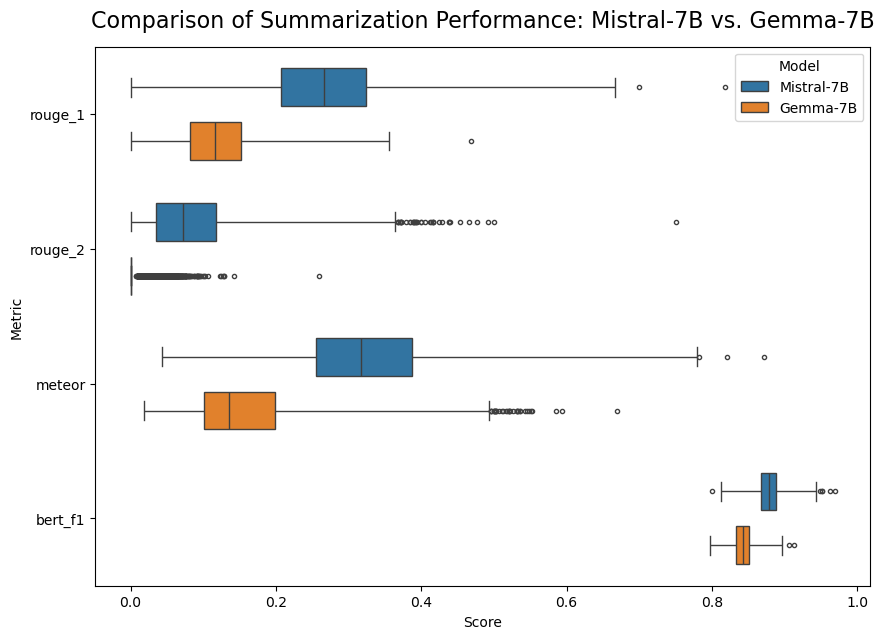

In [10]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='score', y='metric', hue='model_id', data=melted_df, gap=0.3, fliersize=3, whis=3)
plt.title('Comparison of Summarization Performance: Mistral-7B vs. Gemma-7B', fontsize=16, pad=14)
plt.xlabel('Score')
plt.ylabel('Metric')
plt.legend(title='Model')
# plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()

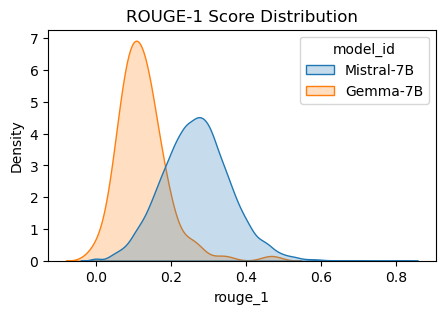

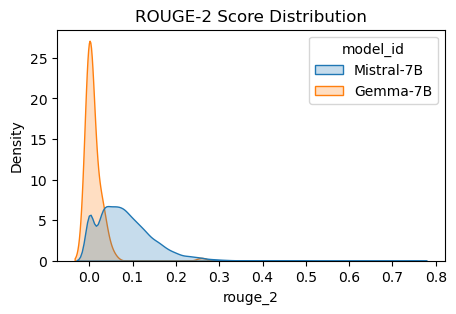

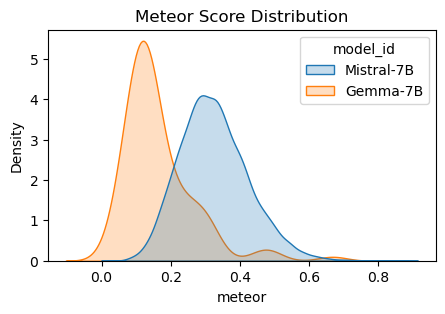

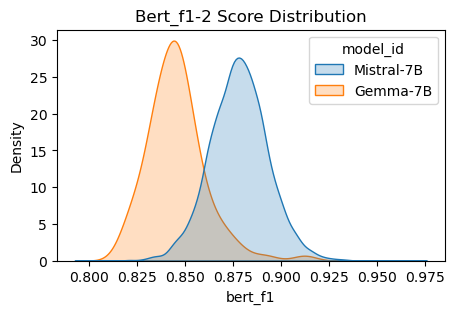

In [ ]:
# Density Plot
plt.figure(figsize=(5, 3))
sns.kdeplot(data=df_combined, x='rouge_1', hue='model_id', fill=True, common_norm=False)
plt.title('ROUGE-1 Score Distribution')
plt.show()

plt.figure(figsize=(5, 3))
sns.kdeplot(data=df_combined, x='rouge_2', hue='model_id', fill=True, common_norm=False)
plt.title('ROUGE-2 Score Distribution')
plt.show()

# Density Plot
plt.figure(figsize=(5, 3))
sns.kdeplot(data=df_combined, x='meteor', hue='model_id', fill=True, common_norm=False)
plt.title('Meteor Score Distribution')
plt.show()

plt.figure(figsize=(5, 3))
sns.kdeplot(data=df_combined, x='bert_f1', hue='model_id', fill=True, common_norm=False)
plt.title('Bert_f1-2 Score Distribution')
plt.show()


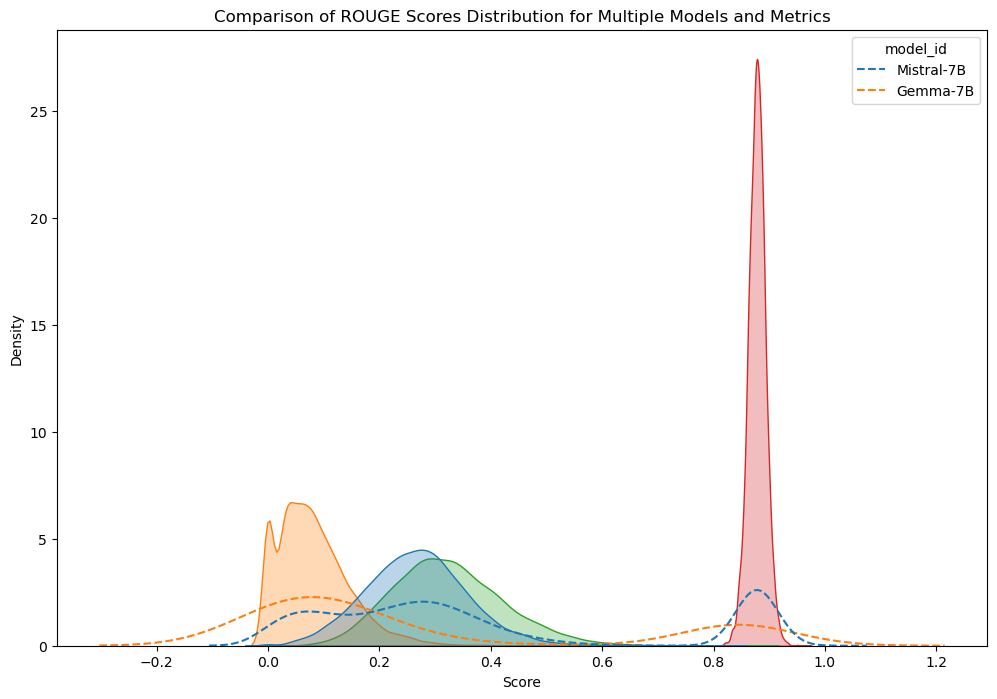

In [ ]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=melted_df, x='score', hue='metric', fill=True, common_norm=False, palette="tab10", alpha=0.3)
sns.kdeplot(data=melted_df, x='score', hue='model_id', fill=False, common_norm=False, palette="tab10", linestyle="--")
plt.title('Comparison of ROUGE Scores Distribution for Multiple Models and Metrics')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

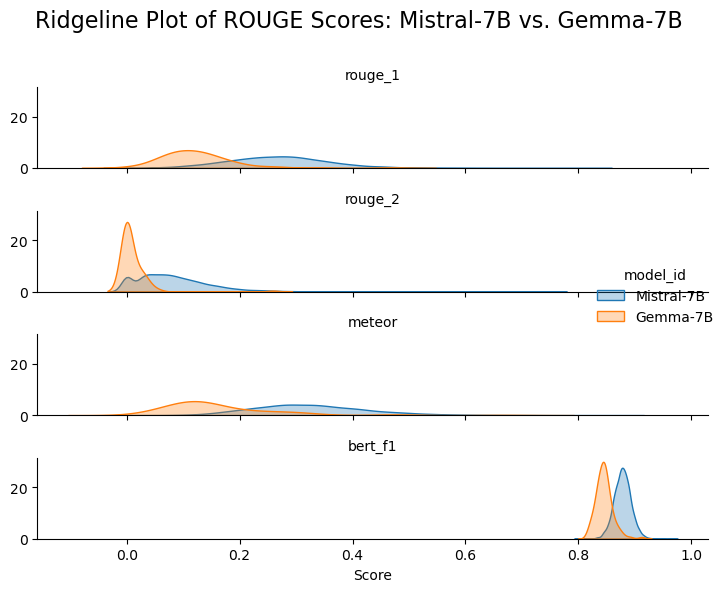

In [ ]:
g = sns.FacetGrid(melted_df, row='metric', hue='model_id', aspect=4, height=1.5)
g.map(sns.kdeplot, 'score', fill=True, alpha=0.3)
g.set_titles(row_template="{row_name}")
g.set_axis_labels("Score", "")
g.figure.suptitle("Ridgeline Plot of ROUGE Scores: Mistral-7B vs. Gemma-7B", fontsize=16)
g.add_legend()
g.figure.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

In [10]:
mistral_time_memory_df = pd.read_csv("/pub/gaog5/copilot/Datasets/mistral_summary_results.csv")
gemma_time_memory_df = pd.read_csv("/pub/gaog5/copilot/Datasets/gemma_summary_results.csv")
mistral_time_memory_df.describe()

,dialogue_id,Time Taken (s),GPU Usage (MB)
count,12427.000000,12427.000000,12427.000000
mean,6214.000000,0.644041,236.850986
std,3587.510232,0.082565,19.032949
min,1.000000,0.482282,188.913262
25%,3107.500000,0.587857,224.003184
50%,6214.000000,0.632349,236.717480
75%,9320.500000,0.682641,247.919434
max,12427.000000,0.967282,311.105488


In [11]:
gemma_time_memory_df.describe()

,dialogue_id,Time Taken (s),GPU Usage (MB)
count,12427.000000,12427.000000,12427.000000
mean,6214.000000,0.746005,823.424249
std,3587.510232,0.083330,56.595262
min,1.000000,0.553492,656.576250
25%,3107.500000,0.681030,784.726914
50%,6214.000000,0.738925,825.625820
75%,9320.500000,0.814531,863.859883
max,12427.000000,1.183100,1011.066914


In [ ]:
cols = ["Time Taken (s)", "GPU Usage (MB)"]
mistral_time_memory_df = mistral_time_memory_df[cols]
mistral_time_memory_df["Model"] = "Mistral-7B"

gemma_time_memory_df = gemma_time_memory_df[cols]
gemma_time_memory_df["Model"] = "Gemma-7B"

time_memory_df_combined = pd.concat([mistral_time_memory_df, gemma_time_memory_df], ignore_index=True)

time_memory_df_combined

,Time Taken (s),GPU Usage (MB),Model
0,0.554711,213.601387,Mistral-7B
1,0.554711,213.601387,Mistral-7B
2,0.554711,213.601387,Mistral-7B
3,0.554711,213.601387,Mistral-7B
4,0.554711,213.601387,Mistral-7B
...,...,...,...
24849,1.183100,923.228253,Gemma-7B
24850,1.183100,923.228253,Gemma-7B
24851,1.183100,923.228253,Gemma-7B
24852,1.183100,923.228253,Gemma-7B


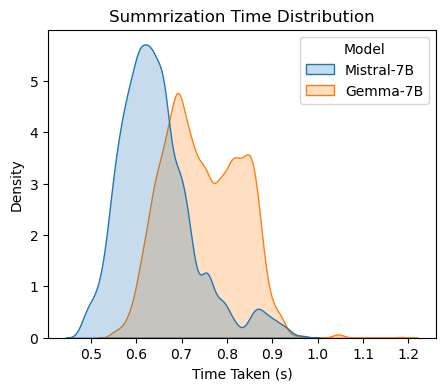

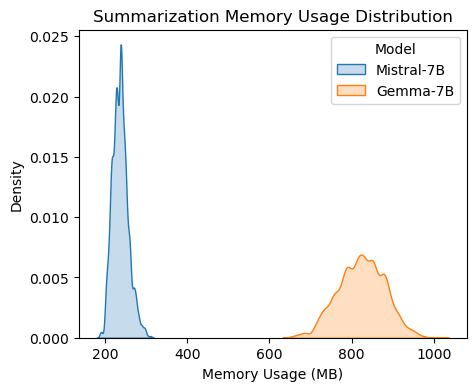

In [ ]:
plt.figure(figsize=(5, 4))
sns.kdeplot(data=time_memory_df_combined, x='Time Taken (s)', hue='Model', fill=True, common_norm=False)
plt.title('Summrization Time Distribution')
plt.show()

plt.figure(figsize=(5, 4))
sns.kdeplot(data=time_memory_df_combined, x='GPU Usage (MB)', hue='Model', fill=True, common_norm=False)
plt.title('Summarization Memory Usage Distribution')
plt.xlabel("Memory Usage (MB)")
plt.show()